In [1]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import torch
from torch.nn import functional
from unpack_mnist import get_labeled_data,  view_image

# Загрузка данных mnist для обучения

In [4]:
X, y = get_labeled_data('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')

i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000
i: 10000
i: 11000
i: 12000
i: 13000
i: 14000
i: 15000
i: 16000
i: 17000
i: 18000
i: 19000
i: 20000
i: 21000
i: 22000
i: 23000
i: 24000
i: 25000
i: 26000
i: 27000
i: 28000
i: 29000
i: 30000
i: 31000
i: 32000
i: 33000
i: 34000
i: 35000
i: 36000
i: 37000
i: 38000
i: 39000
i: 40000
i: 41000
i: 42000
i: 43000
i: 44000
i: 45000
i: 46000
i: 47000
i: 48000
i: 49000
i: 50000
i: 51000
i: 52000
i: 53000
i: 54000
i: 55000
i: 56000
i: 57000
i: 58000
i: 59000


# Реализация ограниченной машины Больцмана

In [55]:
class RBM:
    
    def __init__(self, X, y=None, hidden_number=500, learning_rate=0.01):
        """X - входные данных [n_samples, n_features]
        w – матрица весов [n_features+1, hidden_number+1]"""
        self.X = X
        self.y = y
        self.visible_number = X.shape[1]
        self.hidden_number = hidden_number
        self.learning_rate = learning_rate
        self.w = rand(self.visible_number + 1, hidden_number + 1) - .5
        
        self.v_0_extended_placeholder = ones(self.visible_number + 1)
        self.v_k_extended_placeholder = ones(self.visible_number + 1)
        self.h_0_extended_placeholder = ones(self.hidden_number + 1)
        self.h_k_extended_placeholder = ones(self.hidden_number + 1)
    
    def _sigmoid(self, x):
        return 1 / (1 + exp(-x))
    
    def _sampling(self, p):
        #return (p - 0.5 >= 0).astype(float)
        return (p - rand(*p.shape) >= 0).astype(float)
        #return p
    
    def v_from_h(self, h, activation_func=None):
        if activation_func is None:
            activation_func = self._sigmoid
        h_extended = ones(self.hidden_number + 1)
        h_extended[:-1] = h
        p_v = activation_func(matmul(self.w, h_extended.reshape((-1, 1))))[:-1].reshape(-1)   # todo проверить шейп
        return self._sampling(p_v)
    
    def h_from_v(self, v, activation_func=None):
        if activation_func is None:
            activation_func = self._sigmoid
        v_extended = ones(self.visible_number + 1)
        v_extended[:-1] = v
        p_h = activation_func(matmul(self.w.T, v_extended.reshape((-1, 1))))[:-1].reshape(-1)
        return self._sampling(p_h)
    
    def _cd_pass(self, v, k=2):
        v_0 = (v - 0.5 >= 0).astype(float)    # приведение v к двоичному виду
        h_0 = self.h_from_v(v)
        
        v_k = copy(v_0)
        h_k = copy(h_0)
        for i in range(k):
            v_k = self.v_from_h(h_k)
            h_k = self.h_from_v(v_k)
        
        self.v_0_extended_placeholder[:-1] = v_0
        self.v_k_extended_placeholder[:-1] = v_k
        self.h_0_extended_placeholder[:-1] = h_0
        self.h_k_extended_placeholder[:-1] = h_k
        self.w += self.learning_rate * (matmul(self.v_0_extended_placeholder.reshape((-1, 1)), self.h_0_extended_placeholder.reshape((-1, 1)).T) - matmul(self.v_k_extended_placeholder.reshape((-1, 1)), self.h_k_extended_placeholder.reshape((-1, 1)).T))
    
    def train(self):
        for i in range(X.shape[0]):
            if i % 5000 == 0:
                print(f'i: {i}')
            self._cd_pass(self.X[i])
    
    def predict(self, v):
        h = self.h_from_v(v)
        return self.v_from_h(h)

# Обучение RBM на данных mnist

In [56]:
rbm = RBM(X.reshape((-1, 784)), y.reshape(-1), hidden_number=100)

In [57]:
rbm.train()

i: 0


/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


i: 5000
i: 10000
i: 15000
i: 20000
i: 25000
i: 30000
i: 35000
i: 40000
i: 45000
i: 50000
i: 55000


# Визуализация построенные сетью изображений

/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


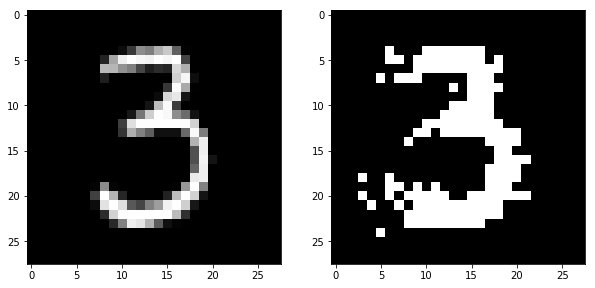

In [100]:
img = X[50]
pred = rbm.predict(img.reshape((-1, 784))).reshape((28, 28))
figsize(10, 5)
fig, (axes1, axes2) = subplots(nrows=1, ncols=2)
axes1.imshow(img, cmap=cm.gray)
axes2.imshow(pred, cmap=cm.gray)

# Визуализация матриц весов

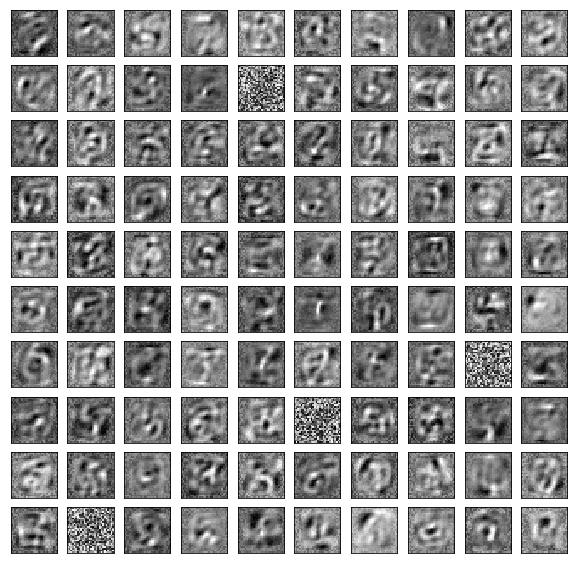

In [78]:
w = rbm.w - rbm.w.min()
w = w / rbm.w.max()
w = w[:-1, :-1]

figsize(10, 10)
fig, axes = subplots(nrows=10, ncols=10)
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.imshow(w[:, i].reshape((28, 28)), cmap=cm.gray)
        i += 1